# <font color='red'>Backtest vectorizado para una estrategia 'Regresion lineal' definida.</font>

### Hackeado by J3viton (learning BackTesting 2021).

---

En este notebook vamos a automatizar el backtesting para estrategias. Previamente tenemos que definir **la estrategia** usando el template (import estrategia_XX as rg), donde definimos la clase estrategia que contiene los metodos de analisis, entreda y salida de mercado. Este módulo se programa y adapta para cada estrategia. Luego en el metodo 'analisis' se crea un fichero excel con las metricas y rendimientos para evaluar la estrategia.

Vamos a usar el módulo Pandas, para realizar un backtest vectorizado, es decir calcular el resultado del backtest sin iterar sobre las filas (barras) de la serie temporal.

Posteriormente graficamos y mostramos los parametros generales que nos permiten analizar la estrategia.

#### J3Viton  2021

link a la base:

https://github.com/Python-para-Trading/Webinars-Docs/blob/master/Webinar%202/Webinar%202%20-%20Backtest%20con%20Pandas%20v%202.ipynb.

---

# DEFINICION DEL SISTEMA

Como es usual, importamos los módulos que vamos a necesitar para las distintas tareas, y preparamos Matplotlib para una mejor visualización de los gráficos en el notebook.

Se importa un modulo llamado analisis, en realidad se trata de un archivo .py con algunas funciones de apoyo para el trabajo, debe estar guardado en la misma carpeta que este notebook.
Se importa el módulo 'estrategia_XX', donde se define la estrategia de entreda y salida

Es importante tener clara la lógica del sistema, pues debemos plasmarla de forma sencilla y correcta en el dataframe para realizar el backtest del mismo.


In [1]:
import analisis
import regresionAMedia as rg  #cambiar segun el módulo con la estrategia implementado
import pandas as pd
import datetime as dt
from time import time
import yfinance as yf
import numpy as np

{'first_name': 'vital_bot', 'username': 'vital_quant_bot', 'is_bot': True, 'can_read_all_group_messages': False, 'supports_inline_queries': False, 'can_join_groups': True, 'id': 1473252352}


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 18, 8
plt.style.use('ggplot')

from IPython.display import display, Markdown

***0.- RECOGIDA DE DATOS INICIALES***
Introducimos el instrumento y las fechas


In [3]:
instrumento_ = 'mts.mc'   # ticker del valor en yahooFinance

Fecha_Cominezo_Backtesting = dt.datetime(2018,1,2)
Fecha_Final_Backtesting    = dt.datetime(2021,11,18)
Fecha_Final_Backtesting    = dt.datetime.today()




***1.- Rango fechas a analizar***

Definimos el rango global de datos historicos que vamos a evaluar.
Definimos la ventana que vamos a ir desplazando por todo el espectro para ir analilazando como se comporta la estrategia. La funion 'analisis' nos vale para tiempo real y para backtesting, para back le pasamos la ventana como si la fecha de fin de la ventana fuera la fecha de hoy.
Tener en cuenta que la 'ventana' tiene uqe tener una anchura que nos permita hacer los calculos en rolling (ejemplo EMA 200)

In [4]:
# Rango completo para backTesting
#start2 =dt.datetime(2008,1,2)
start2= Fecha_Cominezo_Backtesting 
#end2   =dt.datetime(2021,11,18)
end2= Fecha_Final_Backtesting 
start_G= start2.strftime("%Y-%m-%d")
end_G  =   end2.strftime("%Y-%m-%d")
TOTAL_len= (end2-start2).days
print('Tamaño timeseries global a analizar:  ', TOTAL_len, 'sesiones')

#ventana de analisis 200 sesiones
startWindow2 = start2  #dt.datetime(2008,1,5)
endWindow2   =startWindow2 + dt.timedelta(days=500) #ventana grande para que se puedan hacer los calculos de EMA200
startWindow= startWindow2.strftime("%Y-%m-%d")
endWindow  =   endWindow2.strftime("%Y-%m-%d")
window_len= (endWindow2-startWindow2).days
print('Tamaño de la ventana a analizar paso a paso:  ', window_len, 'sesiones')

Tamaño timeseries global a analizar:   1464 sesiones
Tamaño de la ventana a analizar paso a paso:   1000 sesiones


In [5]:
 #dff = pd.DataFrame(columns=('Close','Volume', 'Senal', 'Dif_Close', 'Retornos','Capital'))

***2.- Descargamos los datos para el marco Global***

In [6]:
instrumento = instrumento_  # 'rovi.mc'  #Vamos título a título. Mejora: Conjunto de títulos

In [7]:
dff = yf.download(instrumento, start_G,end_G)

[*********************100%***********************]  1 of 1 completed


In [8]:
dff.dropna(inplace=True)  
dff.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,27.115,27.990000,26.865000,27.990000,26.990908,672626
2018-01-03,28.100,28.799999,28.045000,28.730000,27.704494,804532
2018-01-04,29.020,29.049999,28.549999,28.655001,27.632170,457767
2018-01-05,28.600,28.650000,28.330000,28.389999,27.376629,528866
2018-01-08,28.695,29.215000,28.695000,29.215000,28.172180,758128


***3.- Creamos la clase strategy que tiene toda la lógica***

In [9]:
regreMedia= rg.StrategyClass(real_back=True)    #Creamos la clase

***4.- Recorremos el dataframe con valores buscando las señales de la estrategia***

In [10]:
dff.index

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-15',
               ...
               '2021-12-20', '2021-12-21', '2021-12-22', '2021-12-23',
               '2021-12-27', '2021-12-28', '2021-12-29', '2021-12-30',
               '2022-01-03', '2022-01-04'],
              dtype='datetime64[ns]', name='Date', length=1025, freq=None)

## Proceso de backTesting ##

En este 'for' vamos recorriendo la muestra del historico de datos (TOTAL), desplazando una sesión hacia el futuro 
en cada iteracion. Vamos pasando la movilola del pasado sesión a sesión por el análisis descrito en Strategy class.

Ouput:
El sistema registra los siguientes parámetros:

.-
.-
.-


In [11]:
startWindow

'2018-01-02'

In [12]:
tiempo_inicial = time()   # Tomamos tiempos para ver cuanto tarda en hacer la estrategia

In [13]:
dfe = pd.DataFrame({'A' : []})   #df empty

***En este 'for' desplazamos la ventana sesión a sesión a lo largo de todo el rango de fechas. Dejamos que las funciones de la clase estrategia hagan el trabajo de comprar//vender y anotar***


In [14]:
#Para pruebas
#TOTAL_len =1000

for i in range(TOTAL_len):
    endWindow3   =endWindow2 + dt.timedelta(days=i) 
    endWindow    =endWindow3.strftime("%Y-%m-%d")
    print ('end date:', endWindow)
    
    if(endWindow in dff.index):
        df_aux= dff.loc[startWindow:endWindow]       #voy pasando los datos desplazando la ventana
        
        recogo = regreMedia.analisis(instrumento, startWindow, endWindow, df_aux) #Llamada a la clase estrategia. LA CLAVE DE TODO!!!
        
        print ('................................................Analizando, muestra', i, 'de', TOTAL_len, 'fecha', endWindow)
        
        """
        Tratamiento de los returns, mejor en las funciones de analisis que hacer aquí.
        if(recogo['senal'] == 1 ):
            dff.loc[[endWindow],['Senal']]= 1
        elif(recogo['senal'] == 0 ):
            dff.loc[[endWindow],['Senal']]= 0
        elif(recogo['senal'] == -1 ):
            dff.loc[[endWindow],['Senal']]= -1            
        elif(recogo['senal'] == 503 ):
            dff.loc[[endWindow],['Senal']]= 0          
        """
            
    else:
        print('..............Día sin sesión, next please')

        

end date: 2020-09-28
 datos desde archivo
Coefficients: 
 [-0.0318043]
Independent term: 
 29.32474356619627
Coefficients: 
 [-0.0264184]
Independent term: 
 13.639965935465115
Coefficients: 
 [-0.02992653]
Independent term: 
 16.306013234180888
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 0 de 14

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.03158783]
Independent term: 
 29.27419687259359
Coefficients: 
 [-0.02284853]
Independent term: 
 13.18766413887935
Coefficients: 
 [-0.02970151]
Independent term: 
 16.190357404515424
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 4 de 1464 fecha 2020-10-02


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 10 de 1464 fecha 2020-10-08
end date: 2020-10-09
 datos desde archivo
Coefficients: 
 [-0.03128407]
Independent term: 
 29.20281145637312
Coefficients: 
 [-0.01821684]
Independent term: 
 12.634030264171203
Coefficients: 
 [-0.02923156]
Independent term

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

Coefficients: 
 [-0.01553652]
Independent term: 
 12.313048635881337
Coefficients: 
 [-0.02885277]
Independent term: 
 15.9209113563145
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 16 de 1464 fecha 2020-10-14
end date: 2020-10-15
 datos desde archivo
Coefficients: 
 [-0.03105195]
Independent term:

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

Coefficients: 
 [-0.03086713]
Independent term: 
 29.103989917347363
Coefficients: 
 [-0.01205535]
Independent term: 
 11.906982379457844
Coefficients: 
 [-0.02824688]
Independent term: 
 15.769622756893941
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 22 de 1464 fecha 2020-10-20
end date: 2020-10-

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.03061592]
Independent term: 
 29.04399267079595
Coefficients: 
 [-0.00842479]
Independent term: 
 11.494011327686595
Coefficients: 
 [-0.02752237]
Independent term: 
 15.607943081483167
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 28 de 1464 fecha 2020-10-2

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

Coefficients: 
 [-0.02648048]
Independent term: 
 15.394213494441317
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 35 de 1464 fecha 2020-11-02
end date: 2020-11-03
 datos desde archivo
Coefficients: 
 [-0.03028423]
Independent term: 
 28.96421560926627
Coefficients: 
 [-0.0039458]
Independent term:

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.03009701]
Independent term: 
 28.91890695789705
Coefficients: 
 [-0.0015945]
Independent term: 
 10.716977452733623
Coefficients: 
 [-0.02555033]
Independent term: 
 15.215744057150005
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 39 de 1464 fecha 2020-11-06

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

Coefficients: 
 [-0.02988032]
Independent term: 
 28.86625166131077
Coefficients: 
 [0.00109369]
Independent term: 
 10.445982955818746
Coefficients: 
 [-0.0247878]
Independent term: 
 15.077268898131939
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 44 de 1464 fecha 2020-11-11
end date: 2020-11-12


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.02965818]
Independent term: 
 28.812047556648245
Coefficients: 
 [0.00402201]
Independent term: 
 10.150144593324235
Coefficients: 
 [-0.02396759]
Independent term: 
 14.93480683969604
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 49 de 1464 fecha 2020-11-16

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 53 de 1464 fecha 2020-11-20
end date: 2020-11-21
..............Día sin sesión, next please
end date: 2020-11-22
..............Día sin sesión, next please
end date: 2020-11-23
 datos desde archivo
Coefficients: 
 [-0.02927609]
Independent term: 
 28.71830764

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.02872823]
Independent term: 
 28.582887337025202
Coefficients: 
 [0.02025091]
Independent term: 
 8.46915967485798
Coefficients: 
 [-0.0201385]
Independent term: 
 14.339970692039527
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 64 de 1464 fecha 2020-12-01
e

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 67 de 1464 fecha 2020-12-04
end date: 2020-12-05
..............Día sin sesión, next please
end date: 2020-12-06
..............Día sin sesión, next please
end date: 2020-12-07
 datos desde archivo
Coefficients: 
 [-0.02830673]
Independent term: 
 28.47799825

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.02798723]
Independent term: 
 28.398123012307853
Coefficients: 
 [0.03048018]
Independent term: 
 7.574126714948397
Coefficients: 
 [-0.01699962]
Independent term: 
 13.906604361598227
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 73 de 1464 fecha 2020-12-10

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w


................................................Analizando, muestra 78 de 1464 fecha 2020-12-15
end date: 2020-12-16
 datos desde archivo
Coefficients: 
 [-0.02753915]
Independent term: 
 28.285571859906227
Coefficients: 
 [0.03597443]
Independent term: 
 7.139479253470007
Coefficients: 
 [-0.01500324]
Independent term: 
 13.647386862143723
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.16999

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.02706427]
Independent term: 
 28.165665483218667
Coefficients: 
 [0.03968982]
Independent term: 
 6.9699977613562965
Coefficients: 
 [-0.0129069]
Independent term: 
 13.387317095978407
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 85 de 1464 fecha 2020-12-22

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.02682684]
Independent term: 
 28.105478822787013
Coefficients: 
 [0.04112194]
Independent term: 
 6.942352092871026
Coefficients: 
 [-0.01184325]
Independent term: 
 13.259731610471485
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 87 de 1464 fecha 2020-12-24

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.02647675]
Independent term: 
 28.016438579059052
Coefficients: 
 [0.04271241]
Independent term: 
 6.969325540386029
Coefficients: 
 [-0.01024527]
Independent term: 
 13.073404517779409
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 93 de 1464 fecha 2020-12-30

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 98 de 1464 fecha 2021-01-04
end date: 2021-01-05
 datos desde archivo
Coefficients: 
 [-0.02611935]
Independent term: 
 27.925179944255735
Coefficients: 
 [0.04479195]
Independent term: 
 6.93873643312881
Coefficients: 
 [-0.00864115]
Independent term: 

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 101 de 1464 fecha 2021-01-07
end date: 2021-01-08
 datos desde archivo
Coefficients: 
 [-0.02573972]
Independent term: 
 27.827869699229982
Coefficients: 
 [0.04751153]
Independent term: 
 6.845928062111583
Coefficients: 
 [-0.00700732]
Independent term: 
 

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.0254942]
Independent term: 
 27.764730599258627
Coefficients: 
 [0.04909114]
Independent term: 
 6.808081801329085
Coefficients: 
 [-0.00590484]
Independent term: 
 12.598011504347339
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 106 de 1464 fecha 2021-01-12

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

Coefficients: 
 [-0.02525423]
Independent term: 
 27.702857255328308
Coefficients: 
 [0.0504785]
Independent term: 
 6.790594484628136
Coefficients: 
 [-0.00479533]
Independent term: 
 12.48310778551744
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 108 de 1464 fecha 2021-01-14
end date: 2021-01-15


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

Coefficients: 
 [-0.00368193]
Independent term: 
 12.370256199075541
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 112 de 1464 fecha 2021-01-18
end date: 2021-01-19
 datos desde archivo
Coefficients: 
 [-0.02491089]
Independent term: 
 27.614047748418386
Coefficients: 
 [0.05253109]
Independent ter

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.02469641]
Independent term: 
 27.55839124149323
Coefficients: 
 [0.05389931]
Independent term: 
 6.712203143034408
Coefficients: 
 [-0.00200012]
Independent term: 
 12.203616069886623
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 115 de 1464 fecha 2021-01-21

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.02450031]
Independent term: 
 27.507374151555826
Coefficients: 
 [0.05479187]
Independent term: 
 6.7172643310632285
Coefficients: 
 [-0.00087881]
Independent term: 
 12.094836988683626
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 119 de 1464 fecha 2021-01-

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w


................................................Analizando, muestra 120 de 1464 fecha 2021-01-26
end date: 2021-01-27
 datos desde archivo
Coefficients: 
 [-0.02431277]
Independent term: 
 27.458459002473067
Coefficients: 
 [0.05545001]
Independent term: 
 6.7448386667023845
Coefficients: 
 [0.00023369]
Independent term: 
 11.98875859632817
bye
Operacion poco eficiente
***************** NoGo
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7   

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 122 de 1464 fecha 2021-01-28
end date: 2021-01-29
 datos desde archivo
Coefficients: 
 [-0.02412147]
Independent term: 
 27.40843431067796
Coefficients: 
 [0.05612052]
Independent term: 
 6.7747682132293905
Coefficients: 
 [0.00133776]
Independent term: 
 1

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 126 de 1464 fecha 2021-02-01
end date: 2021-02-02
 datos desde archivo
Coefficients: 
 [-0.02393121]
Independent term: 
 27.358554912610657
Coefficients: 
 [0.0568871]
Independent term: 
 6.79098402115836
Coefficients: 
 [0.00243374]
Independent term: 
 11.

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 128 de 1464 fecha 2021-02-03
end date: 2021-02-04
 datos desde archivo
Coefficients: 
 [-0.02374552]
Independent term: 
 27.309749500461862
Coefficients: 
 [0.05756437]
Independent term: 
 6.814505207787699
Coefficients: 
 [0.00352172]
Independent term: 
 1

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 130 de 1464 fecha 2021-02-05
end date: 2021-02-06
..............Día sin sesión, next please
end date: 2021-02-07
..............Día sin sesión, next please
end date: 2021-02-08
 datos desde archivo
Coefficients: 
 [-0.02354815]
Independent term: 
 27.2577415

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

Coefficients: 
 [0.00515168]
Independent term: 
 11.54127711148863
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 134 de 1464 fecha 2021-02-09
end date: 2021-02-10
 datos desde archivo
Coefficients: 
 [-0.02334854]
Independent term: 
 27.205010093139688
Coefficients: 
 [0.05977402]
Independent term:

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.02325238]
Independent term: 
 27.17956082795022
Coefficients: 
 [0.06026322]
Independent term: 
 6.7713291139745
Coefficients: 
 [0.00623815]
Independent term: 
 11.446867749806373
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 136 de 1464 fecha 2021-02-11
en

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.02295279]
Independent term: 
 27.10006649975783
Coefficients: 
 [0.06191063]
Independent term: 
 6.746761940557563
Coefficients: 
 [0.00786509]
Independent term: 
 11.308411640746998
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 141 de 1464 fecha 2021-02-16


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.0227557]
Independent term: 
 27.047607389482245
Coefficients: 
 [0.06244674]
Independent term: 
 6.8025997020237465
Coefficients: 
 [0.00894408]
Independent term: 
 11.218833081112805
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 143 de 1464 fecha 2021-02-18

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 144 de 1464 fecha 2021-02-19
end date: 2021-02-20
..............Día sin sesión, next please
end date: 2021-02-21
..............Día sin sesión, next please
end date: 2021-02-22
 datos desde archivo
Coefficients: 
 [-0.02255272]
Independent term: 
 26.9934464

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 148 de 1464 fecha 2021-02-23
end date: 2021-02-24
 datos desde archivo
Coefficients: 
 [-0.02235472]
Independent term: 
 26.94048086604129
Coefficients: 
 [0.06320875]
Independent term: 
 6.962614765167236
Coefficients: 
 [0.01105933]
Independent term: 
 11

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 [0.01158154]
Independent term: 
 11.00941139292907
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 150 de 1464 fecha 2021-02-25
end date: 2021-02-26
 datos desde archivo
Coefficients: 
 [-0.02215596]
Independent term: 
 26.887181051701162
Coefficients: 
 [0.06372688]
Independent term: 
 7.0225758099

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

Coefficients: 
 [-0.02205474]
Independent term: 
 26.859986042074457
Coefficients: 
 [0.06396685]
Independent term: 
 7.057123564962129
Coefficients: 
 [0.01261648]
Independent term: 
 10.930809866510124
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 154 de 1464 fecha 2021-03-01
end date: 2021-03-02

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.02184234]
Independent term: 
 26.802816492129388
Coefficients: 
 [0.06455467]
Independent term: 
 7.122765653809503
Coefficients: 
 [0.01364195]
Independent term: 
 10.855089611104779
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 156 de 1464 fecha 2021-03-03

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.02164378]
Independent term: 
 26.74923876767989
Coefficients: 
 [0.06503693]
Independent term: 
 7.187385951511896
Coefficients: 
 [0.01465738]
Independent term: 
 10.782139368158562
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 158 de 1464 fecha 2021-03-05


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

Coefficients: 
 [-0.02143053]
Independent term: 
 26.691554135122338
Coefficients: 
 [0.06572807]
Independent term: 
 7.240552088182363
Coefficients: 
 [0.0156655]
Independent term: 
 10.711711086541566
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 162 de 1464 fecha 2021-03-09
end date: 2021-03-10


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.02121549]
Independent term: 
 26.633239866127006
Coefficients: 
 [0.06654816]
Independent term: 
 7.278773431493273
Coefficients: 
 [0.01666812]
Independent term: 
 10.643620622331046
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 164 de 1464 fecha 2021-03-11

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.02098029]
Independent term: 
 26.569304874956586
Coefficients: 
 [0.06789732]
Independent term: 
 7.269456401369463
Coefficients: 
 [0.01767569]
Independent term: 
 10.576872024605166
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 168 de 1464 fecha 2021-03-15

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

Coefficients: 
 [-0.02074573]
Independent term: 
 26.505387786756327
Coefficients: 
 [0.06933027]
Independent term: 
 7.248832820778463
Coefficients: 
 [0.01869194]
Independent term: 
 10.511033222913952
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 170 de 1464 fecha 2021-03-17
end date: 2021-03-18

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.02050423]
Independent term: 
 26.43941758600813
Coefficients: 
 [0.07069552]
Independent term: 
 7.245520419362765
Coefficients: 
 [0.0197154]
Independent term: 
 10.446337947612275
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 172 de 1464 fecha 2021-03-19
e

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.02028168]
Independent term: 
 26.378479075966318
Coefficients: 
 [0.07154698]
Independent term: 
 7.289460581452099
Coefficients: 
 [0.02073786]
Independent term: 
 10.383606462835498
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 176 de 1464 fecha 2021-03-23

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 177 de 1464 fecha 2021-03-24
end date: 2021-03-25
 datos desde archivo
Coefficients: 
 [-0.02005954]
Independent term: 
 26.31750175739176
Coefficients: 
 [0.07246677]
Independent term: 
 7.324171625535877
Coefficients: 
 [0.02175775]
Independent term: 
 10

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.01981344]
Independent term: 
 26.249783459469313
Coefficients: 
 [0.07375833]
Independent term: 
 7.337166555034579
Coefficients: 
 [0.02278163]
Independent term: 
 10.26362083558978
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 182 de 1464 fecha 2021-03-29


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.01955724]
Independent term: 
 26.17911564818379
Coefficients: 
 [0.07508061]
Independent term: 
 7.358034473817741
Coefficients: 
 [0.02381063]
Independent term: 
 10.205984464959897
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 184 de 1464 fecha 2021-03-31


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.019304]
Independent term: 
 26.109094266958515
Coefficients: 
 [0.07632749]
Independent term: 
 7.385945065768798
Coefficients: 
 [0.02484473]
Independent term: 
 10.14994598175141
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 190 de 1464 fecha 2021-04-06
en

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 [0.02587962]
Independent term: 
 10.095950493085086
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 192 de 1464 fecha 2021-04-08
end date: 2021-04-09
 datos desde archivo
Coefficients: 
 [-0.01893385]
Independent term: 
 26.006438526327017
Coefficients: 
 [0.07786171]
Independent term: 
 7.461850293

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.01881232]
Independent term: 
 25.97265258168784
Coefficients: 
 [0.07834769]
Independent term: 
 7.488530287102088
Coefficients: 
 [0.02691377]
Independent term: 
 10.044056856735626
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 196 de 1464 fecha 2021-04-12


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

Coefficients: 
 [-0.01856685]
Independent term: 
 25.904289109288
Coefficients: 
 [0.07939299]
Independent term: 
 7.535192229569848
Coefficients: 
 [0.02794712]
Independent term: 
 9.994213032955592
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 198 de 1464 fecha 2021-04-14
end date: 2021-04-15
 da

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 199 de 1464 fecha 2021-04-15
end date: 2021-04-16
 datos desde archivo
Coefficients: 
 [-0.01832093]
Independent term: 
 25.835635999957987
Coefficients: 
 [0.08050452]
Independent term: 
 7.573965062383396
Coefficients: 
 [0.02898163]
Independent term: 
 9

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.01808735]
Independent term: 
 25.770275264353394
Coefficients: 
 [0.08140475]
Independent term: 
 7.626662825257032
Coefficients: 
 [0.03001625]
Independent term: 
 9.899889114203688
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 204 de 1464 fecha 2021-04-20


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w


Independent term: 
 9.856000449702028
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 206 de 1464 fecha 2021-04-22
end date: 2021-04-23
 datos desde archivo
Coefficients: 
 [-0.01773547]
Independent term: 
 25.671512145240484
Coefficients: 
 [0.08266799]
Independent term: 
 7.719694778243108
Coeffic

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.01760904]
Independent term: 
 25.635941268904094
Coefficients: 
 [0.08326901]
Independent term: 
 7.737868221055212
Coefficients: 
 [0.03207246]
Independent term: 
 9.813879244455707
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 210 de 1464 fecha 2021-04-26


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 214 de 1464 fecha 2021-04-30
end date: 2021-05-01
..............Día sin sesión, next please
end date: 2021-05-02
..............Día sin sesión, next please
end date: 2021-05-03
 datos desde archivo
Coefficients: 
 [-0.01702412]
Independent term: 
 25.4708090

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

Coefficients: 
 [-0.01678869]
Independent term: 
 25.404063884031167
Coefficients: 
 [0.08601282]
Independent term: 
 7.984724009926639
Coefficients: 
 [0.03564955]
Independent term: 
 9.682197075588164
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 219 de 1464 fecha 2021-05-05
end date: 2021-05-06


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 221 de 1464 fecha 2021-05-07
end date: 2021-05-08
..............Día sin sesión, next please
end date: 2021-05-09
..............Día sin sesión, next please
end date: 2021-05-10
 datos desde archivo
Coefficients: 
 [-0.01639891]
Independent term: 
 25.2932333

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

Coefficients: 
 [-0.01614172]
Independent term: 
 25.219890050598913
Coefficients: 
 [0.08836753]
Independent term: 
 8.18498058988087
Coefficients: 
 [0.03817786]
Independent term: 
 9.6048946064849
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 226 de 1464 fecha 2021-05-12
end date: 2021-05-13
 da

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 228 de 1464 fecha 2021-05-14
end date: 2021-05-15
..............Día sin sesión, next please
end date: 2021-05-16
..............Día sin sesión, next please
end date: 2021-05-17
 datos desde archivo
Coefficients: 
 [-0.01576906]
Independent term: 
 25.1133111

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.01531429]
Independent term: 
 24.982722785718614
Coefficients: 
 [0.08995325]
Independent term: 
 8.59830623825984
Coefficients: 
 [0.04164547]
Independent term: 
 9.524324978043218
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 235 de 1464 fecha 2021-05-21
e

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.01509762]
Independent term: 
 24.920285041919016
Coefficients: 
 [0.09017754]
Independent term: 
 8.72271472489656
Coefficients: 
 [0.04260591]
Independent term: 
 9.507793814243504
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 239 de 1464 fecha 2021-05-25
e

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.01487368]
Independent term: 
 24.85560238251899
Coefficients: 
 [0.09034284]
Independent term: 
 8.864252495267497
Coefficients: 
 [0.0435498]
Independent term: 
 9.49437772828632
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 241 de 1464 fecha 2021-05-27
end

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.01464087]
Independent term: 
 24.788202462425232
Coefficients: 
 [0.09062092]
Independent term: 
 9.00210323362208
Coefficients: 
 [0.04448031]
Independent term: 
 9.483959024091845
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 245 de 1464 fecha 2021-05-31
e

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.0143977]
Independent term: 
 24.717644842022445
Coefficients: 
 [0.09099258]
Independent term: 
 9.140763687304593
Coefficients: 
 [0.04539986]
Independent term: 
 9.47643175062763
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 247 de 1464 fecha 2021-06-02
en

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

248 de 1464 fecha 2021-06-03
end date: 2021-06-04
 datos desde archivo
Coefficients: 
 [-0.01416327]
Independent term: 
 24.649465271832188
Coefficients: 
 [0.09112702]
Independent term: 
 9.299931893135183
Coefficients: 
 [0.04630451]
Independent term: 
 9.472175968761544
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
...............................................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 252 de 1464 fecha 2021-06-07
end date: 2021-06-08
 datos desde archivo
Coefficients: 
 [-0.01393923]
Independent term: 
 24.584155683421123
Coefficients: 
 [0.09107783]
Independent term: 
 9.470305475263451
Coefficients: 
 [0.04719123]
Independent term: 
 9

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

Coefficients: 
 [0.04762722]
Independent term: 
 9.472191397593164
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 254 de 1464 fecha 2021-06-09
end date: 2021-06-10
 datos desde archivo
Coefficients: 
 [-0.01371787]
Independent term: 
 24.51948106302472
Coefficients: 
 [0.09100148]
Independent term: 

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.01360326]
Independent term: 
 24.485939932777324
Coefficients: 
 [0.09106141]
Independent term: 
 9.718284430575014
Coefficients: 
 [0.04848669]
Independent term: 
 9.476302248206013
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 256 de 1464 fecha 2021-06-11


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 259 de 1464 fecha 2021-06-14
end date: 2021-06-15
 datos desde archivo
Coefficients: 
 [-0.01339051]
Independent term: 
 24.423569108176846
Coefficients: 
 [0.09084214]
Independent term: 
 9.896877436993725
Coefficients: 
 [0.04932723]
Independent term: 
 9

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
................................................Analizando, muestra 261 de 1464 fecha 2021-06-16
end date: 2021-06-17
 datos desde archivo
Coefficients: 
 [-0.01320365]
Independent term: 
 24.36866706764326
Coefficients: 
 [0.09006473]
Independent term: 
 10.116034318439997
Coefficients: 
 [0.05013827]
Independent term: 
 9

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC             1.0  2011-08-10    4.776000        NaN       NaN
1        MSFT             0.0  2014-01-08   35.759998   1.350209      99.0
2      san.mc             1.0  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc             0.0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC             0.0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC             1.0  2013-06-25   15.020000   1.652717      99.0
6      mts.MC             1.0  2021-09-21   24.670000   5.460217      99.0
7        nvda             0.0  2021-09-29  205.169998  13.604359      99.0
8      mts.mc             1.0  2021-06-17   24.389999   3.738981      99.0
................................................Analizando, muestra 262 de 1464 fecha 2021-06-17
end date: 2021-06-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 263 de 1464 fecha 2021-06

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")


aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 267 de 1464 fecha 2021-06-22
end date: 2021-06-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 268 de 1464 fecha 2021-06-23
end date: 2021-06-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 269 de 1464 fecha 2021-06-24
end date: 2021-06-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 270 de 1464 fecha 2021-06-25
end date: 2021-06-26
..............Día sin sesión, next please
end date: 2021-06-27
..............Día sin sesión, next please
end date: 2021-06-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 273 de 1464 fecha 2021-06-28
end date: 2021-06-29
aqui estoy en out
 datos desde archivo
................................................An

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.0103599]
Independent term: 
 23.51775040273991
Coefficients: 
 [0.07705378]
Independent term: 
 13.63230357682527
Coefficients: 
 [0.05861965]
Independent term: 
 10.149319382215381
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
8      mts.mc               0  2021-06-17   24.389999   3.738981      99.0
.......................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.01014472]
Independent term: 
 23.452228611510048
Coefficients: 
 [0.07664684]
Independent term: 
 13.84112910783113
Coefficients: 
 [0.05897908]
Independent term: 
 10.221360978329088
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
8      mts.mc               0  2021-06-17   24.389999   3.738981      99.0
.....................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.00992917]
Independent term: 
 23.386450060521934
Coefficients: 
 [0.07622908]
Independent term: 
 14.052076122369337
Coefficients: 
 [0.05932271]
Independent term: 
 10.296177470783551
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
8      mts.mc               0  2021-06-17   24.389999   3.738981      99.0
....................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
8      mts.mc               0  2021-06-17   24.389999   3.738981      99.0
................................................Analizando, muestra 311 de 1464 fecha 2021-08-05
end date: 2021-08-06
 datos desde archivo
Coefficients: 
 [-0.00971674]
Independent term: 
 23.321481448532655
Coefficients: 
 [0.075713]
Independent ter

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
8      mts.mc               0  2021-06-17   24.389999   3.738981      99.0
................................................Analizando, muestra 315 de 1464 fecha 2021-08-09
end date: 2021-08-10
 datos desde archivo
Coefficients: 
 [-0.00949699]
Independent term: 
 23.25412790403296
Coefficients: 
 [0.07508238]
Independent te

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
8      mts.mc               0  2021-06-17   24.389999   3.738981      99.0
................................................Analizando, muestra 317 de 1464 fecha 2021-08-11
end date: 2021-08-12
 datos desde archivo
Coefficients: 
 [-0.00927085]
Independent term: 
 23.184666023127193
Coefficients: 
 [0.07450965]
Independent t

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
8      mts.mc               0  2021-06-17   24.389999   3.738981      99.0
................................................Analizando, muestra 319 de 1464 fecha 2021-08-13
end date: 2021-08-14
..............Día sin sesión, next please
end date: 2021-08-15
..............Día sin sesión, next please
end date: 2021-08-16
 datos

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

Coefficients: 
 [-0.00894298]
Independent term: 
 23.08368472754456
Coefficients: 
 [0.07357975]
Independent term: 
 15.127479377291095
Coefficients: 
 [0.06065349]
Independent term: 
 10.670795180364049
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
8      mts.mc               0  2021-06-17   24.389999   3.738981      99.0
..........................................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.00874715]
Independent term: 
 23.02320709048371
Coefficients: 
 [0.07247404]
Independent term: 
 15.401777898873856
Coefficients: 
 [0.06089446]
Independent term: 
 10.763038219474726
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
8      mts.mc               0  2021-06-17   24.389999   3.738981      99.0
.....................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
8      mts.mc               0  2021-06-17   24.389999   3.738981      99.0
................................................Analizando, muestra 326 de 1464 fecha 2021-08-20
end date: 2021-08-21
..............Día sin sesión, next please
end date: 2021-08-22
..............Día sin sesión, next please
end date: 2021-08-23
 datos

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
8      mts.mc               0  2021-06-17   24.389999   3.738981      99.0
................................................Analizando, muestra 330 de 1464 fecha 2021-08-24
end date: 2021-08-25
 datos desde archivo
Coefficients: 
 [-0.00836608]
Independent term: 
 22.905136091273445
Coefficients: 
 [0.07045461]
Independent t

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.00807862]
Independent term: 
 22.815736758657742
Coefficients: 
 [0.06906434]
Independent term: 
 16.27747818434416
Coefficients: 
 [0.06153952]
Independent term: 
 11.111184379272622
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
8      mts.mc               0  2021-06-17   24.389999   3.738981      99.0
.....................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.00789966]
Independent term: 
 22.759929531189687
Coefficients: 
 [0.06781679]
Independent term: 
 16.54675894708776
Coefficients: 
 [0.06167039]
Independent term: 
 11.217442828850793
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
8      mts.mc               0  2021-06-17   24.389999   3.738981      99.0
.....................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.00772201]
Independent term: 
 22.704415129944618
Coefficients: 
 [0.06656373]
Independent term: 
 16.814958792159807
Coefficients: 
 [0.06177353]
Independent term: 
 11.326974800877938
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
8      mts.mc               0  2021-06-17   24.389999   3.738981      99.0
....................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")


 datos desde archivo
Coefficients: 
 [-0.00763307]
Independent term: 
 22.67657787234665
Coefficients: 
 [0.06611142]
Independent term: 
 16.9261785023248
Coefficients: 
 [0.0618167]
Independent term: 
 11.382688270544076
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
8      mts.mc               0  2021-06-17   24.389999   3.738981      99.0
........................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

 datos desde archivo
Coefficients: 
 [-0.00745886]
Independent term: 
 22.621962589661962
Coefficients: 
 [0.06511732]
Independent term: 
 17.155386854712642
Coefficients: 
 [0.06188742]
Independent term: 
 11.495823584493097
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
8      mts.mc               0  2021-06-17   24.389999   3.738981      99.0
....................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
8      mts.mc               0  2021-06-17   24.389999   3.738981      99.0
................................................Analizando, muestra 346 de 1464 fecha 2021-09-09
end date: 2021-09-10
 datos desde archivo
Coefficients: 
 [-0.00729329]
Independent term: 
 22.569944787898883
Coefficients: 
 [0.06388739]
Independent t

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

Coefficients: 
 [-0.0072114]
Independent term: 
 22.544176336015877
Coefficients: 
 [0.06337261]
Independent term: 
 17.512995497290767
Coefficients: 
 [0.06194746]
Independent term: 
 11.670299228203682
bye
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
8      mts.mc               0  2021-06-17   24.389999   3.738981      99.0
..........................................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
8      mts.mc               0  2021-06-17   24.389999   3.738981      99.0
................................................Analizando, muestra 351 de 1464 fecha 2021-09-14
end date: 2021-09-15
 datos desde archivo
Coefficients: 
 [-0.00704608]
Independent term: 
 22.49207264667883
Coefficients: 
 [0.06247575]
Independent te

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
8      mts.mc               0  2021-06-17   24.389999   3.738981      99.0
................................................Analizando, muestra 353 de 1464 fecha 2021-09-16
end date: 2021-09-17
 datos desde archivo
Coefficients: 
 [-0.00688665]
Independent term: 
 22.441721834571936
Coefficients: 
 [0.06166369]
Independent t

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
8      mts.mc               1  2021-09-17   27.215000   3.019491      99.0
................................................Analizando, muestra 354 de 1464 fecha 2021-09-17
end date: 2021-09-18
..............Día sin sesión, next please
end date: 2021-09-19
..............Día sin sesión, next please
end date: 2021-09-20
aqui e

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.w

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      IBE.MC               1  2011-08-10    4.776000        NaN       NaN
1        MSFT               0  2014-01-08   35.759998   1.350209      99.0
2      san.mc               1  2021-07-08    3.057500   0.532204      99.0
3      ibe.mc               0  2021-06-25   10.355000   0.797811      99.0
4      REE.MC               0  2019-07-08   17.695000   1.585407      99.0
5     ntgy.MC               1  2013-06-25   15.020000   1.652717      99.0
6      mts.MC               1  2021-09-21   24.670000   5.460217      99.0
7        nvda               0  2021-09-29  205.169998  13.604359      99.0
8      mts.mc               1  2021-09-21   24.670000   5.460217      99.0
................................................Analizando, muestra 358 de 1464 fecha 2021-09-21
end date: 2021-09-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 359 de 1464 fecha 2021-09

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")


aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 364 de 1464 fecha 2021-09-27
end date: 2021-09-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 365 de 1464 fecha 2021-09-28
end date: 2021-09-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 366 de 1464 fecha 2021-09-29
end date: 2021-09-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 367 de 1464 fecha 2021-09-30
end date: 2021-10-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 368 de 1464 fecha 2021-10-01
end date: 2021-10-02
..............Día sin sesión, next please
end date: 2021-10-03
..............Día sin sesión, next please
end date: 2021-10-04
aqui estoy en out
 datos desde archivo
................................................An

................................................Analizando, muestra 428 de 1464 fecha 2021-11-30
end date: 2021-12-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 429 de 1464 fecha 2021-12-01
end date: 2021-12-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 430 de 1464 fecha 2021-12-02
end date: 2021-12-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 431 de 1464 fecha 2021-12-03
end date: 2021-12-04
..............Día sin sesión, next please
end date: 2021-12-05
..............Día sin sesión, next please
end date: 2021-12-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 434 de 1464 fecha 2021-12-06
end date: 2021-12-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 435 de 1464 fecha 202

..............Día sin sesión, next please
end date: 2022-05-30
..............Día sin sesión, next please
end date: 2022-05-31
..............Día sin sesión, next please
end date: 2022-06-01
..............Día sin sesión, next please
end date: 2022-06-02
..............Día sin sesión, next please
end date: 2022-06-03
..............Día sin sesión, next please
end date: 2022-06-04
..............Día sin sesión, next please
end date: 2022-06-05
..............Día sin sesión, next please
end date: 2022-06-06
..............Día sin sesión, next please
end date: 2022-06-07
..............Día sin sesión, next please
end date: 2022-06-08
..............Día sin sesión, next please
end date: 2022-06-09
..............Día sin sesión, next please
end date: 2022-06-10
..............Día sin sesión, next please
end date: 2022-06-11
..............Día sin sesión, next please
end date: 2022-06-12
..............Día sin sesión, next please
end date: 2022-06-13
..............Día sin sesión, next please
end date: 202

..............Día sin sesión, next please
end date: 2023-09-04
..............Día sin sesión, next please
end date: 2023-09-05
..............Día sin sesión, next please
end date: 2023-09-06
..............Día sin sesión, next please
end date: 2023-09-07
..............Día sin sesión, next please
end date: 2023-09-08
..............Día sin sesión, next please
end date: 2023-09-09
..............Día sin sesión, next please
end date: 2023-09-10
..............Día sin sesión, next please
end date: 2023-09-11
..............Día sin sesión, next please
end date: 2023-09-12
..............Día sin sesión, next please
end date: 2023-09-13
..............Día sin sesión, next please
end date: 2023-09-14
..............Día sin sesión, next please
end date: 2023-09-15
..............Día sin sesión, next please
end date: 2023-09-16
..............Día sin sesión, next please
end date: 2023-09-17
..............Día sin sesión, next please
end date: 2023-09-18
..............Día sin sesión, next please
end date: 202

***Recogemos los datos de las entradas que ha realizado la Estrategia***

In [15]:
data=rg.StrategyClass.dfLog
#data.dropna(inplace=True) 

In [16]:
data.tail()

,Date,Senal,Price,Objetivo,ExitReason,Beneficio
2021-12-28,2021-12-28,1,28.65,NaN,NaN,NaN
2021-12-29,2021-12-29,1,28.73,NaN,NaN,NaN
2021-12-30,2021-12-30,1,28.375,NaN,NaN,NaN
2022-01-03,2022-01-03,1,28.635,NaN,NaN,NaN
2022-01-04,2022-01-04,1,28.959999,NaN,NaN,NaN


<AxesSubplot:title={'center':'Señales de compra de la estrategia '}>

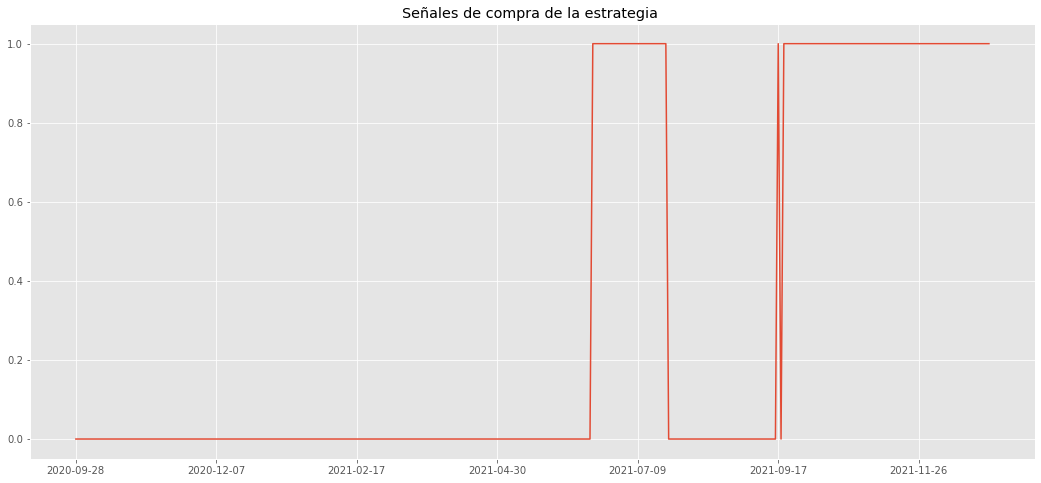

In [17]:
data['Senal'].plot(title = 'Señales de compra de la estrategia ' )
# Ploteando una parte
#data.loc['2010':'2022','Senal'].plot(title = 'Señales Regresión a la media ' +instrumento,xlim=('2010','2022'))

In [18]:
tiempo_final = time() 
 
tiempo_ejecucion = tiempo_final - tiempo_inicial
 
print ('El tiempo de ejecucion fue:',tiempo_ejecucion,"segundos") #En segundos

El tiempo de ejecucion fue: 31.88503098487854 segundos


In [19]:
data.loc['2011-01-04':'2019-11-04']

,Date,Senal,Price,Objetivo,ExitReason,Beneficio


In [20]:
#Guardamos el resultado del analisis en un pickle
#dff.to_pickle("./primerBack_IBE.pkl")

***3.- Ingeniería de datos para calcular la bondad de la estrategia***

In [21]:

data['Dif_Close'] = data.Price.pct_change()
data['Retornos'] = data.Dif_Close * data.Senal.shift(1)   
data['Capital'] = (data.Retornos + 1).cumprod() * 100
    
rg.StrategyClass.dfLog=data  #Ojo a esta liena, no me cuadra.

#quant_j.salvarExcel(StrategyClass.dfLog, "log"+instrumento)   
#data.to_pickle('almacen')    #df = pd.read_pickle(file_name)

>Para calcular los retornos del sistema, calculamos la diferencia relativativa entre el precio de cierre y el del día anterior. Para posteriormente multiplicarlo por la señal que del día anterior que nos indicaba la posición a tomar (si estaba comprado, sumo beneficio).

In [22]:
data.tail()

,Date,Senal,Price,Objetivo,ExitReason,Beneficio,Dif_Close,Retornos,Capital
2021-12-28,2021-12-28,1,28.65,NaN,NaN,NaN,-0.000698,-0.000698,124.399362
2021-12-29,2021-12-29,1,28.73,NaN,NaN,NaN,0.002792,0.002792,124.746725
2021-12-30,2021-12-30,1,28.375,NaN,NaN,NaN,-0.012356,-0.012356,123.205303
2022-01-03,2022-01-03,1,28.635,NaN,NaN,NaN,0.009163,0.009163,124.334234
2022-01-04,2022-01-04,1,28.959999,NaN,NaN,NaN,0.011350,0.01135,125.745391


In [23]:
data[60:]

,Date,Senal,Price,Objetivo,ExitReason,Beneficio,Dif_Close,Retornos,Capital
2020-12-21,2020-12-21,0,18.656,NaN,NaN,NaN,-0.006920,-0.0,100.0
2020-12-22,2020-12-22,0,18.954,NaN,NaN,NaN,0.015973,0.0,100.0
2020-12-23,2020-12-23,0,19.191999,NaN,NaN,NaN,0.012557,0.0,100.0
2020-12-24,2020-12-24,0,19.018,NaN,NaN,NaN,-0.009066,-0.0,100.0
2020-12-28,2020-12-28,0,19.059999,NaN,NaN,NaN,0.002208,0.0,100.0
...,...,...,...,...,...,...,...,...,...
2021-12-28,2021-12-28,1,28.65,NaN,NaN,NaN,-0.000698,-0.000698,124.399362
2021-12-29,2021-12-29,1,28.73,NaN,NaN,NaN,0.002792,0.002792,124.746725
2021-12-30,2021-12-30,1,28.375,NaN,NaN,NaN,-0.012356,-0.012356,123.205303
2022-01-03,2022-01-03,1,28.635,NaN,NaN,NaN,0.009163,0.009163,124.334234


>El capital, por comodidad, lo calcularemos en base 100, es decir como si iniciaramos la inversión con 100 unidades monetarias. Para su calculo arrastramos el producto acumulado de los retornos mas 1, multiplicados como dijimos por 100.

Pero para observar gráficamente la evolución del sistema necesitamos un gráfico con mas información. Para ello definimos una función que nos mostrará un gráfico con la evolución de nuestra estrategia, comparandola con la del activo. En un subgráfico se visualizará el drawdown del sistema, comparado de nuevo con el del activo. Y por útlimo las posiciones que toma el sistema.

In [24]:
def grafico (df):
    estudio = df.copy()
    
    DD_bh, maxDD, maxDD_ini, maxDD_fin = analisis.DrawDown(estudio.Dif_Close[60:], info = False) 
    
    DD, maxDD, maxDD_ini, maxDD_fin = analisis.DrawDown(estudio.Retornos.fillna(0), info = False) 

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(18, 12), gridspec_kw = {'height_ratios':[3, 1, 1]})
    fig.suptitle('Estrategia vs B & H', fontsize=20)

    #Primer plot analiza la evolcuion de una inversion de 100€ en buy&hold y la estrategia)
    ax1.plot(estudio.Capital)
    ax1.plot((estudio.Price) * (100/estudio.Price[1]))
    ax1.set_title('Capital')
    ax1.legend(['Estrategia','Buy & Hold'])

    ax2.plot(DD*100, c='0.5')
    ax2.plot(DD_bh*100, c='y')
    ax2.fill_between(DD.index, 0, DD*100, color='0.7')
    ax2.set_title('Drawdown')
    ax2.legend(['Estrategia','Buy & Hold'])

    ax3.plot(estudio.Senal, c='orange')
    #ax3.fill_between(estudio.index, 0, estudio.Senal*100, color='orange')
    ax3.set_title('Posición')

    plt.show()
    return

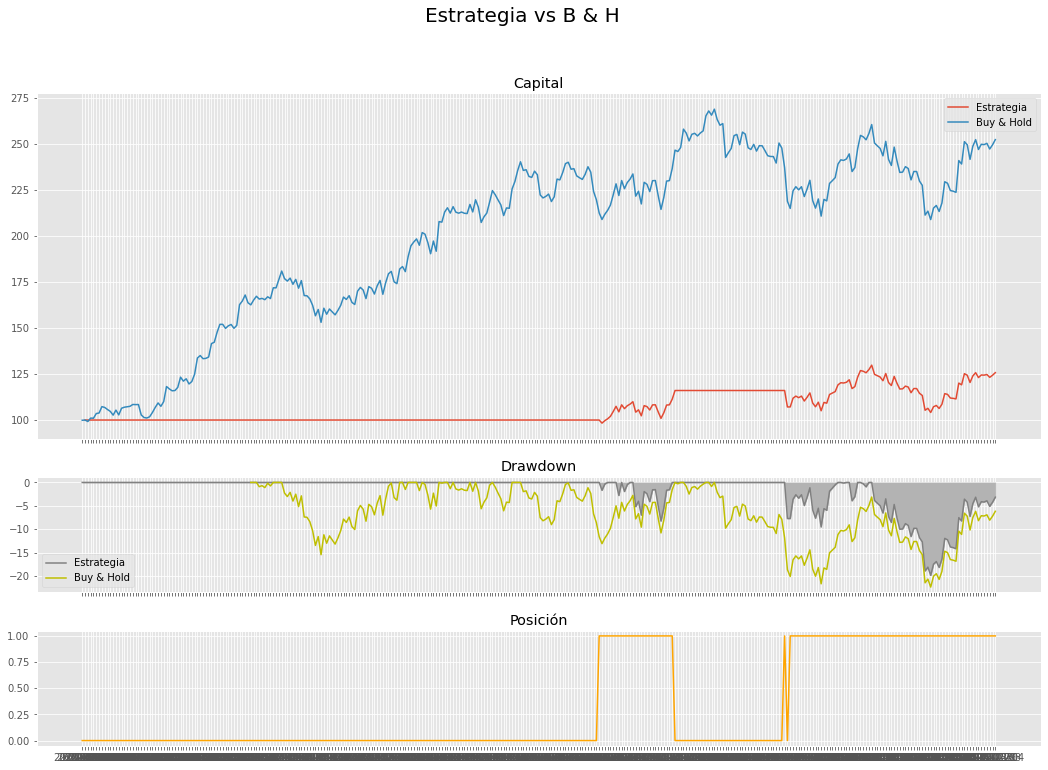

In [25]:
grafico(data)

---

In [26]:
#data[55:70]

---

# ANALISIS DEL SISTEMA

In [27]:
Beneficio_Bruto = data.Capital[-1] - data.Capital[1]
print ('Beneficio Bruto : {:.2f} €  con una inverison de 100€'.format(Beneficio_Bruto))

Beneficio Bruto : 25.75 €  con una inverison de 100€


In [28]:
#Rentabilidad anual compuesta. Calculamos lo que la inversion se ha incrementado cada año con el interes compuesto
CAGR = analisis.CAGR(data.Retornos)
print ('CAGR : {:.2f}%'.format(CAGR * 100))

CAGR : 19.84%


In [29]:
#Ratio calculado restando una rentabilidad segura a nuestra rentabilidad de estrategia y dividido por el riego (=volatilidad)
data.Retornos=data.Retornos.replace(0,np.e)  #Quito los cero (no sepuede hacer logariotmo de cero), pero no se que poner
Sharpe = CAGR / (np.log(data.Retornos + 1).std(skipna=True) * 252 ** 0.5)
print ('Sharpe : {:.3f}'.format(CAGR ))

Sharpe : 0.198


In [30]:
# Actualizo la excel con los economic
regreMedia.analisisEconomics(instrumento)

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\regresionLineal_MediaMovil\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")


---


---